In [3]:
from pathlib import Path

# Try common base paths automatically
possible_paths = [
    Path("/home/jovyan/prohibited_items/CLCXray"),
    Path("/home/javyon/prohibited_items/CLCXray"),
    Path("/prohibited_items/CLCXray"),
    Path.cwd() / "CLCXray",
    Path.cwd() / "prohibited_items" / "CLCXray",
]

BASE_DIR = None
for p in possible_paths:
    if p.exists():
        BASE_DIR = p
        break

if BASE_DIR is None:
    raise SystemExit("❌ Could not find CLCXray dataset. Please verify the path manually.")
else:
    print(f"✅ CLCXray dataset found at: {BASE_DIR}")

# Display subfolders to verify structure
print("📂 Subfolders found:", [f.name for f in BASE_DIR.iterdir() if f.is_dir()])


✅ CLCXray dataset found at: /home/jovyan/prohibited_items/CLCXray
📂 Subfolders found: ['annotations', 'train2017', 'val2017', 'test2017', '.ipynb_checkpoints']


In [ ]:
#CELL 1 — Setup Environment and Paths
import os
from pathlib import Path

# Define dataset base path
BASE_DIR = Path("/home/jovyan/prohibited_items/CLCXray")

# Check dataset structure
assert (BASE_DIR / "annotations").exists(), "Annotations folder missing!"
assert (BASE_DIR / "train2017").exists(), "train2017 folder missing!"
assert (BASE_DIR / "val2017").exists(), "val2017 folder missing!"
assert (BASE_DIR / "test2017").exists(), "test2017 folder missing!"

# JSON annotation paths
TRAIN_JSON = BASE_DIR / "annotations/instances_train2017.json"
VAL_JSON = BASE_DIR / "annotations/instances_val2017.json"
TEST_JSON = BASE_DIR / "annotations/instances_test2017.json"

# Writable YOLO workspace
YOLO_DIR = Path.home() / "CLCXray_yolo"
YOLO_DIR.mkdir(exist_ok=True)

# Output directory
OUTPUT_DIR = YOLO_DIR / "output"
OUTPUT_DIR.mkdir(exist_ok=True)

print("✅ Dataset structure verified.")
print("YOLO workspace:", YOLO_DIR)
print("Output folder:", OUTPUT_DIR)


✅ Dataset structure verified.
YOLO workspace: /home/jovyan/CLCXray_yolo
Output folder: /home/jovyan/CLCXray_yolo/output


In [ ]:
#  CELL 2 — Install Dependencies
!pip install ultralytics pycocotools tqdm opencv-python-headless pillow matplotlib --quiet

from ultralytics import YOLO
import matplotlib.pyplot as plt
import os


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/jovyan/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Robust COCO -> YOLO converter (handles None and bad bboxes)
import json
from pathlib import Path
import shutil, math, sys, os
from collections import defaultdict

# Set base (auto-detected earlier). Update if needed.
BASE_DIR = Path("/home/jovyan/prohibited_items/CLCXray")
assert BASE_DIR.exists(), f"{BASE_DIR} not found"

ANN_DIR = BASE_DIR / "annotations"
TRAIN_JSON = ANN_DIR / "instances_train2017.json"
VAL_JSON   = ANN_DIR / "instances_val2017.json"
TEST_JSON  = ANN_DIR / "instances_test2017.json"

YOLO_DIR = Path.home() / "CLCXray_yolo"
for p in [YOLO_DIR, YOLO_DIR/"train"/"images", YOLO_DIR/"train"/"labels", YOLO_DIR/"val"/"images", YOLO_DIR/"val"/"labels", YOLO_DIR/"test"/"images", YOLO_DIR/"test"/"labels"]:
    p.mkdir(parents=True, exist_ok=True)

# helper to safe float
def is_valid_num(x):
    try:
        if x is None: return False
        x = float(x)
        if math.isfinite(x): return True
        return False
    except:
        return False

# load a COCO json and process
def process_coco_json(json_path, images_dir, out_images_dir, out_labels_dir, catid2class, verbose=True):
    with open(json_path, "r", encoding="utf-8") as f:
        coco = json.load(f)
    images = {img['id']: img for img in coco.get('images', [])}
    anns = coco.get('annotations', [])
    cats = {c['id']: c['name'] for c in coco.get('categories', [])}

    # map category ids found in JSON to class ids we will use
    # If user already wants specific classes, catid2class can map numeric cat_id -> class_index
    # otherwise we will build a mapping from categories in JSON to sequential class ids
    if not catid2class:
        unique_cats = sorted(list(cats.items()), key=lambda x: x[0])  # list of (cat_id, name)
        catid2class = {cid: i for i, (cid, _) in enumerate(unique_cats)}
    else:
        # ensure every JSON category exists in mapping; for new unseen cat ids assign next available index
        next_idx = max(catid2class.values())+1 if catid2class else 0
        for cid in cats:
            if cid not in catid2class:
                catid2class[cid] = next_idx
                next_idx += 1

    # counters
    inst_count = defaultdict(int)
    image_has_label = defaultdict(set)  # class_name -> set(image_name)
    written_labels = 0
    missing_images = 0
    skipped_invalid = 0

    for ann in anns:
        # each ann should have 'image_id', 'bbox', 'category_id'
        img_id = ann.get("image_id")
        bbox = ann.get("bbox")
        cat_id = ann.get("category_id")

        # validate basic fields
        if img_id not in images:
            if verbose:
                print("WARN: annotation references missing image_id:", img_id)
            missing_images += 1
            continue
        img_info = images[img_id]
        img_filename = img_info.get("file_name")
        img_w = img_info.get("width", None)
        img_h = img_info.get("height", None)

        # validate bbox
        if not bbox or len(bbox) < 4:
            skipped_invalid += 1
            continue
        x, y, w, h = bbox[:4]
        if not all(is_valid_num(val) for val in (x,y,w,h)):
            skipped_invalid += 1
            continue
        # filter degenerate boxes
        if w <= 0 or h <= 0:
            skipped_invalid += 1
            continue
        # ensure image exists on disk
        # try various image dirs (train2017/val2017/test2017 under BASE_DIR)
        possible_image_paths = [
            Path(BASE_DIR) / "train2017" / img_filename,
            Path(BASE_DIR) / "val2017" / img_filename,
            Path(BASE_DIR) / "test2017" / img_filename,
            Path(BASE_DIR) / "train2017" / (Path(img_filename).stem + ".jpg"),
            Path(BASE_DIR) / "val2017" / (Path(img_filename).stem + ".jpg"),
            Path(BASE_DIR) / "test2017" / (Path(img_filename).stem + ".jpg"),
        ]
        src_img = None
        for p in possible_image_paths:
            if p.exists():
                src_img = p
                break
        if src_img is None:
            # try fallback: look in the images_dir passed (if provided)
            candidate = Path(images_dir) / img_filename
            if candidate.exists():
                src_img = candidate
        if src_img is None:
            missing_images += 1
            if verbose:
                # print only occasionally to avoid huge logs
                if missing_images < 10:
                    print("WARN: image file not found for", img_filename)
            continue

        # copy image to out_images_dir (once)
        dst_img = Path(out_images_dir) / Path(img_filename).name
        if not dst_img.exists():
            try:
                shutil.copy(src_img, dst_img)
            except Exception as e:
                if verbose:
                    print("WARN: failed to copy", src_img, "->", dst_img, ":", e)
                continue

        # compute YOLO normalized bbox: COCO bbox is [x_min, y_min, width, height]
        # ensure  have image width/height; if missing, try to read using PIL lazily
        if not img_w or not img_h:
            try:
                from PIL import Image
                with Image.open(src_img) as im:
                    img_w, img_h = im.size
            except Exception:
                skipped_invalid += 1
                continue

        x_center = (x + w/2.0) / img_w
        y_center = (y + h/2.0) / img_h
        w_n = w / img_w
        h_n = h / img_h
        # clamp to [0,1]
        x_center = max(0.0, min(1.0, x_center))
        y_center = max(0.0, min(1.0, y_center))
        w_n = max(0.0, min(1.0, w_n))
        h_n = max(0.0, min(1.0, h_n))
        # skip if degenerate after normalization
        if w_n <= 0 or h_n <= 0:
            skipped_invalid += 1
            continue

        # get class id for this category
        cls_id = catid2class.get(cat_id, None)
        if cls_id is None:
            # assign next index
            cls_id = max(catid2class.values(), default=-1) + 1
            catid2class[cat_id] = cls_id

        # write label to file
        label_path = Path(out_labels_dir) / (Path(img_filename).stem + ".txt")
        with open(label_path, "a") as L:
            L.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {w_n:.6f} {h_n:.6f}\n")
        inst_count[cls_id] += 1
        image_has_label[cls_id].add(Path(img_filename).name)
        written_labels += 1

    if verbose:
        print(f"Processed {json_path.name}: wrote {written_labels} bbox lines, skipped {skipped_invalid}, missing images {missing_images}")
    return catid2class, inst_count, image_has_label

# Build a mapping from COCO categories -> indices (we will keep the COCO order)
try:
    with open(TRAIN_JSON, "r", encoding="utf-8") as f:
        train_json = json.load(f)
    coco_cats = train_json.get('categories', [])
    catid2class = {c['id']: i for i,c in enumerate(coco_cats)}
    # Also build names in that order
    class_names = [c['name'] for c in sorted(coco_cats, key=lambda x: catid2class[x['id']])]
except Exception as e:
    # fallback simple mapping; we'll build dynamically
    catid2class = {}
    class_names = []

# Process train/val/test
train_out_images = YOLO_DIR / "train" / "images"
train_out_labels = YOLO_DIR / "train" / "labels"
val_out_images = YOLO_DIR / "val" / "images"
val_out_labels = YOLO_DIR / "val" / "labels"
test_out_images = YOLO_DIR / "test" / "images"
test_out_labels = YOLO_DIR / "test" / "labels"

all_inst = defaultdict(int)
all_imgsets = defaultdict(set)

for json_path, img_dir, out_img, out_lbl in [
    (TRAIN_JSON, BASE_DIR/"train2017", train_out_images, train_out_labels),
    (VAL_JSON,   BASE_DIR/"val2017",   val_out_images,   val_out_labels),
    (TEST_JSON,  BASE_DIR/"test2017",  test_out_images,  test_out_labels),
]:
    if not json_path.exists():
        print("WARN: JSON not found:", json_path)
        continue
    catid2class, inst_count, image_has_label = process_coco_json(json_path, img_dir, out_img, out_lbl, catid2class, verbose=True)
    for k,v in inst_count.items():
        all_inst[k] += v
    for k,v in image_has_label.items():
        all_imgsets[k].update(v)

# If we didn't derive class_names from JSON, build generic names
if not class_names:
    max_idx = max(all_inst.keys()) if all_inst else -1
    class_names = [f"class_{i}" for i in range(max_idx+1)]

# Prepare and print final summary (map indices -> names)
print("\n=== Final class summary ===")
print(f"Total classes detected: {len(class_names)}")
summary = []
for idx in sorted(set(list(all_inst.keys()) + list(range(len(class_names))))):
    name = class_names[idx] if idx < len(class_names) else f"class_{idx}"
    imgs = len(all_imgsets.get(idx, set()))
    inst = all_inst.get(idx, 0)
    summary.append((idx, name, imgs, inst))
    print(f"#{idx:02d} {name:30s} images: {imgs:5d}  instances: {inst:6d}")

# save a simple classes.txt in YOLO_DIR
with open(YOLO_DIR/"classes.txt", "w") as cf:
    for i,name in enumerate(class_names):
        cf.write(f"{i} {name}\n")

print("\nYOLO dataset created at:", YOLO_DIR)
print("Train images:", len(list(train_out_images.glob("*"))))
print("Val images:  ", len(list(val_out_images.glob("*"))))
print("Test images: ", len(list(test_out_images.glob("*"))))



Processed instances_train2017.json: wrote 18373 bbox lines, skipped 0, missing images 0
WARN: image file not found for 07_03_17_890.png
WARN: image file not found for 07_03_17_890.png
WARN: image file not found for 07_05_39_468.png
WARN: image file not found for 07_05_39_468.png
WARN: image file not found for 07_13_25_812.png
WARN: image file not found for 07_16_10_859.png
WARN: image file not found for 07_18_31_296.png
WARN: image file not found for 07_22_34_546.png
WARN: image file not found for 07_57_27_250.png
Processed instances_val2017.json: wrote 1819 bbox lines, skipped 0, missing images 498
Processed instances_test2017.json: wrote 1421 bbox lines, skipped 0, missing images 0

=== Final class summary ===
Total classes detected: 12
#00 blade                          images:  2317  instances:   3450
#01 scissors                       images:  2146  instances:   2447
#02 knife                          images:   673  instances:    691
#03 dagger                         images:   95

In [ ]:
# CELL 4 — Create data.yaml for 12-class CLCXray

yaml_content = f"""
train: {YOLO_DIR}/train/images
val: {YOLO_DIR}/val/images
test: {YOLO_DIR}/test/images

nc: 12
names: [
  'blade',
  'dagger',
  'knife',
  'scissors',
  'swiss_army_knife',
  'cans',
  'carton_drinks',
  'glass_bottle',
  'plastic_bottle',
  'vacuum_cup',
  'spray_cans',
  'tin'
]
"""

yaml_path = YOLO_DIR / "data.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("✅ data.yaml created successfully at:", yaml_path)


✅ data.yaml created successfully at: /home/jovyan/CLCXray_yolo/data.yaml


Train labels found: 7652
Validation labels found: 730


/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


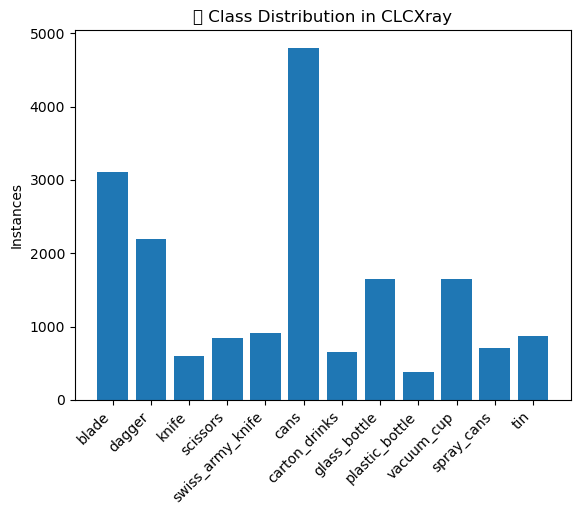

In [ ]:
#  CELL 5 — Quick verification of YOLO labels
from pathlib import Path

train_labels = list((YOLO_DIR / "train" / "labels").glob("*.txt"))
val_labels = list((YOLO_DIR / "val" / "labels").glob("*.txt"))

print(f"Train labels found: {len(train_labels)}")
print(f"Validation labels found: {len(val_labels)}")

# Display class distribution
label_dist = [0] * 12
for label_file in train_labels:
    with open(label_file, "r") as f:
        for line in f:
            cid = int(line.split()[0])
            label_dist[cid] += 1

plt.bar(range(12), label_dist)
plt.xticks(range(12), [
    'blade','dagger','knife','scissors','swiss_army_knife','cans',
    'carton_drinks','glass_bottle','plastic_bottle','vacuum_cup','spray_cans','tin'
], rotation=45, ha='right')
plt.ylabel("Instances")
plt.title("📊 Class Distribution in CLCXray")
plt.show()


📊 Category-wise counts:
Category             Images     Instances 
---------------------------------------------
blade                2090       3105      
dagger               1918       2188      
knife                588        603       
scissors             832        846       
swiss_army_knife     895        909       
cans                 3582       4801      
carton_drinks        619        655       
glass_bottle         1609       1653      
plastic_bottle       289        386       
vacuum_cup           1483       1646      
spray_cans           596        714       
tin                  774        867       


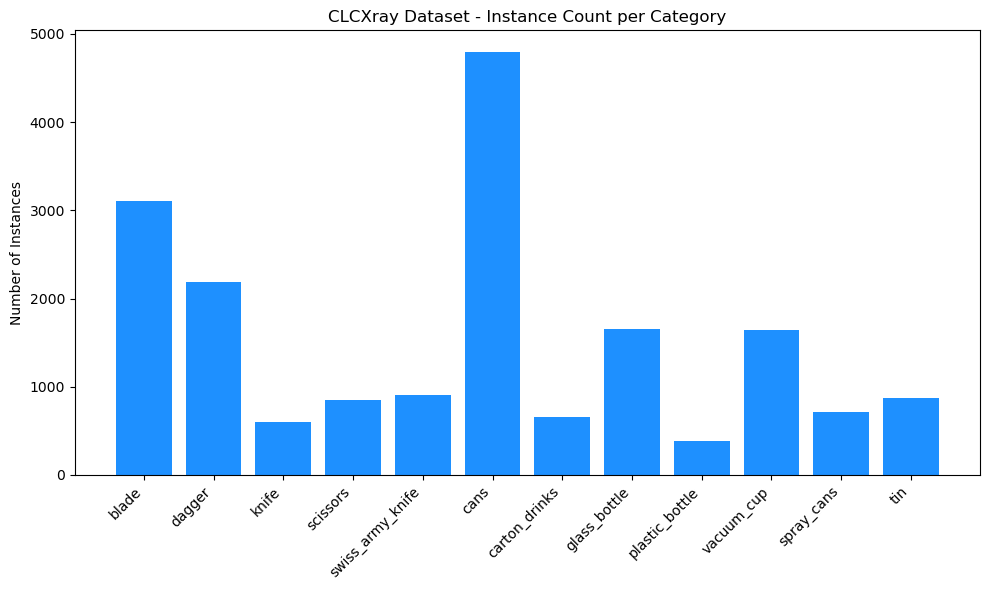

In [ ]:
# CELL — Verify number of images and instances per category in YOLO format

import os
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt

# Path to YOLO labels folder
labels_dir = Path.home() / "CLCXray_yolo" / "train" / "labels"

# Class names (in the correct order)
class_names = [
    'blade',
    'dagger',
    'knife',
    'scissors',
    'swiss_army_knife',
    'cans',
    'carton_drinks',
    'glass_bottle',
    'plastic_bottle',
    'vacuum_cup',
    'spray_cans',
    'tin'
]

# Initialize counters
instance_count = defaultdict(int)
image_per_class = defaultdict(set)

# Parse label files
for label_file in labels_dir.glob("*.txt"):
    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            class_id = int(parts[0])
            if class_id < len(class_names):
                instance_count[class_names[class_id]] += 1
                image_per_class[class_names[class_id]].add(label_file.name)

# Compute per-class image counts
image_count = {cls: len(imgs) for cls, imgs in image_per_class.items()}

# Print summary
print("📊 Category-wise counts:")
print(f"{'Category':<20} {'Images':<10} {'Instances':<10}")
print("-" * 45)
for cls in class_names:
    print(f"{cls:<20} {image_count.get(cls, 0):<10} {instance_count.get(cls, 0):<10}")

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, [instance_count[c] for c in class_names], color='dodgerblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Instances")
plt.title("CLCXray Dataset - Instance Count per Category")
plt.tight_layout()
plt.show()


In [ ]:
#  FINAL TRAINING CODE for CLCXray (verified & balanced)
from ultralytics import YOLO

# Load pretrained YOLOv8 small model
model = YOLO("yolov8s.pt")

# Train
results = model.train(
    data=str(yaml_path),
    epochs=80,                # effective equivalent of 600 from scratch
    imgsz=640,
    batch=8,
    optimizer='SGD',
    lr0=0.01,                 # initial LR (matches paper)
    lrf=0.001,                # final LR (decayed)
    momentum=0.937,           # matches paper
    weight_decay=0.0005,      # matches paper
    patience=10,              # early stopping if no improvement
    
    project=str(YOLO_DIR / "runs"),
    name="clcxray_final_run",
    exist_ok=True
)

print("✅ Training complete. Results stored in:", YOLO_DIR / "runs" / "clcxray_final_run")



Ultralytics 8.3.227 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB MIG 3g.20gb, 20096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jovyan/CLCXray_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=clcxray_final_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patienc

In [ ]:
# CLCXray Testing + Save Detections to JSON
from ultralytics import YOLO
from pathlib import Path
from datetime import datetime
import json, gc

# Define paths properly as Path objects 
BASE = Path.home()
MODEL_PATH = Path("/home/jovyan/CLCXray_yolo/runs/clcxray_final_run/weights/best.pt")
IMAGE_DIR = Path("/home/jovyan/CLCXray_yolo/test/images")
OUTPUT_JSON = Path("/home/jovyan/prohibited_items.json")
LOG_JSON = Path("/home/jovyan/prohibited_items_log.json")

#Check prerequisites 
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"❌ Model not found at {MODEL_PATH}")
if not IMAGE_DIR.exists():
    raise FileNotFoundError(f"❌ Test image folder not found at {IMAGE_DIR}")

#  Gather test images 
image_list = list(IMAGE_DIR.glob("*.png")) + list(IMAGE_DIR.glob("*.jpg"))
if len(image_list) == 0:
    raise FileNotFoundError(f"❌ No test images found in {IMAGE_DIR}")

print(f"📸 Found {len(image_list)} test images. Running CPU-safe inference...")

# Load YOLO model 
model = YOLO(str(MODEL_PATH))

detections = []
logs = {
    "start_time": datetime.now().isoformat(),
    "total_images": len(image_list),
    "images": []
}

# Run inference safely one image at a time 
for i, img_path in enumerate(image_list, 1):
    img_name = img_path.name
    print(f"[{i}/{len(image_list)}] Processing {img_name}...", end=" ")
    try:
        res_list = model.predict(
            source=str(img_path),
            device="cpu",    
            conf=0.25,
            imgsz=640,
            save=False,
            verbose=False
        )
        det_count = 0
        for res in res_list:
            if hasattr(res, "boxes") and res.boxes is not None:
                for box in res.boxes:
                    cls = model.names[int(box.cls)]
                    conf = float(box.conf)
                    det_count += 1
                    detections.append({
                        "timestamp": datetime.now().isoformat(),
                        "filename": img_name,
                        "item_class": cls,
                        "confidence": conf,
                        "anomaly_score": conf,
                        "anomaly_type": f"Prohibited Item Detected: {cls}"
                    })
        logs["images"].append({
            "filename": img_name,
            "detections": det_count,
            "status": "OK"
        })
        print(f"✅ {det_count} detections.")
    except Exception as e:
        logs["images"].append({
            "filename": img_name,
            "status": "ERROR",
            "error": str(e)[:200]
        })
        print(f"⚠️ Error: {str(e)[:150]}")
    finally:
        gc.collect()

# Finalize logs 
logs["end_time"] = datetime.now().isoformat()
logs["total_detections"] = len(detections)

# Save detections & logs 
with open(OUTPUT_JSON, "w") as f:
    json.dump(detections, f, indent=4)
with open(LOG_JSON, "w") as f:
    json.dump(logs, f, indent=4)

print(f"\n✅ Inference complete. Saved:")
print(f"   📄 {OUTPUT_JSON}")
print(f"   🪶 {LOG_JSON}")
print(f"   Total detections: {len(detections)}")


📸 Found 956 test images. Running CPU-safe inference...
✅ 1 detections.ing 07_02_22_171.png... 
[2/956] Processing 09_52_41_945.png... ✅ 3 detections.
[3/956] Processing 09_53_09_428.png... ✅ 1 detections.
[4/956] Processing 19_59_15_000.png... ✅ 1 detections.
[5/956] Processing 19_48_23_406.png... ✅ 1 detections.
[6/956] Processing 06_30_44_281.png... ✅ 2 detections.
[7/956] Processing 18_01_26_031.png... ✅ 1 detections.
[8/956] Processing 09_35_39_087.png... ✅ 1 detections.
[9/956] Processing 06_36_31_359.png... ✅ 1 detections.
[10/956] Processing 20_47_32_750.png... ✅ 1 detections.
[11/956] Processing 17_24_07_531.png... ✅ 1 detections.
[12/956] Processing 18_22_52_421.png... ✅ 1 detections.
[13/956] Processing 06_22_00_718.png... ✅ 1 detections.
[14/956] Processing 09_57_48_828.png... ✅ 1 detections.
[15/956] Processing 15_22_46_281.png... ✅ 1 detections.
[16/956] Processing 09_39_04_363.png... ✅ 2 detections.
[17/956] Processing 13_43_04_390.png... ✅ 2 detections.
[18/956] Processi

In [ ]:

#  FINAL CONTINUATION TRAINING FOR CLCXray (80 epochs)


from ultralytics import YOLO
from pathlib import Path


BASE = Path("/home/jovyan/CLCXray_yolo")
yaml_path = BASE / "data.yaml"

# previously trained model
PRETRAINED_WEIGHTS = BASE / "runs" / "clcxray_final_run" / "weights" / "best.pt"

RUN_NAME = "clcxray_final_run_v3_80ep"

# =======================
# CHECK FILES
# =======================
if not yaml_path.exists():
    raise FileNotFoundError(f"❌ YAML file not found: {yaml_path}")

if not PRETRAINED_WEIGHTS.exists():
    raise FileNotFoundError(f"❌ best.pt not found: {PRETRAINED_WEIGHTS}")

# =======================
# LOAD PREVIOUS MODEL
# =======================
model = YOLO(str(PRETRAINED_WEIGHTS))

# =======================
# CONTINUE TRAINING (80 EPOCHS)
# =======================
results = model.train(
    data=str(yaml_path),
    epochs=80,           
    imgsz=640,
    batch=16,
    workers=4,

    # Anti-overfitting settings
    dropout=0.10,
    mixup=0.3,
    mosaic=1.0,
    fliplr=0.5,
    flipud=0.2,
    degrees=10,
    scale=0.5,
    hsv_s=0.7,
    hsv_v=0.4,

    #  Lower LR for fine-tuning
    optimizer="SGD",
    lr0=0.002,
    lrf=0.0005,
    momentum=0.937,
    weight_decay=0.0005,

    patience=10,

    project=str(BASE / "runs"),
    name=RUN_NAME,
    exist_ok=True
)

print("\n✅ FINAL TRAINING COMPLETE →", BASE / "runs" / RUN_NAME)


New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.227 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB MIG 3g.20gb, 20096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jovyan/CLCXray_yolo/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.2, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.002, lrf=0.0005, mask_ratio=4, max_det=300, mixup=0.3, mode=train, model=/home/jovyan/CLCXray_yolo/runs/clcxray_final_run/weights/best.pt, mome

In [ ]:

#FINAL EVALUATION CODE FOR CLCXRAY YOLOv8 MODEL


from ultralytics import YOLO
from pathlib import Path
import json
from datetime import datetime

# -----------------------------
# PATHS
# -----------------------------
BASE = Path("/home/jovyan/CLCXray_yolo")
RUN_NAME = "clcxray_final_run_v3_80ep"   
MODEL_PATH = BASE / "runs" / RUN_NAME / "weights" / "best.pt"

# dataset YAML
YAML_PATH = BASE / "data.yaml"

# folder to save evaluation results
EVAL_DIR = BASE / "evaluation_output"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

# output JSON file
EVAL_JSON = EVAL_DIR / "evaluation_results.json"

# -----------------------------
# VALIDATE PATHS
# -----------------------------
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"❌ Missing model file: {MODEL_PATH}")

if not YAML_PATH.exists():
    raise FileNotFoundError(f"❌ Missing dataset YAML: {YAML_PATH}")

print("📌 Evaluating model:", MODEL_PATH)

# -----------------------------
# LOAD MODEL
# -----------------------------
model = YOLO(str(MODEL_PATH))

# -----------------------------
# RUN EVALUATION
# -----------------------------
metrics = model.val(
    data=str(YAML_PATH),
    imgsz=640,
    batch=8,
    save_json=True,          # export COCO-style json
    save_hybrid=True,        # save hybrid predictions
    conf=0.001,
    iou=0.65,
    project=str(EVAL_DIR),
    name="metrics",
)

print("\n🎯 EVALUATION COMPLETE")

# -----------------------------
# EXTRACT MAIN METRICS
# -----------------------------
results_dict = {
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "mAP50": float(metrics.box.map50),
    "mAP50_95": float(metrics.box.map),
    "precision": float(metrics.box.mp),
    "recall": float(metrics.box.mr),
    "per_class_mAP50": {},
}

# -----------------------------
#  PER-CLASS mAP EXTRACTION
# -----------------------------
class_names = model.names  # index: class name
per_class_map = metrics.box.maps  # list of mAP50-95 per class

for class_id, map_class in enumerate(per_class_map):
    results_dict["per_class_mAP50"][class_names[class_id]] = round(float(map_class), 4)

# -----------------------------
# SAVE SUMMARY JSON
# -----------------------------
with open(EVAL_JSON, "w") as f:
    json.dump(results_dict, f, indent=4)

print(f"📁 Evaluation results saved to: {EVAL_JSON}")

# -----------------------------
#  PRINT SUMMARY
# -----------------------------
print("\n📊 FINAL METRICS:")
print(f"mAP50      : {results_dict['mAP50']:.4f}")
print(f"mAP50-95   : {results_dict['mAP50_95']:.4f}")
print(f"Precision  : {results_dict['precision']:.4f}")
print(f"Recall     : {results_dict['recall']:.4f}")

print("\n📌 Per-Class mAP50:")
for cls, mp in results_dict["per_class_mAP50"].items():
    print(f"  - {cls:<18} : {mp}")

print("\n📁 All confusion matrices and PR curves saved inside:")
print(f"{EVAL_DIR}/metrics")


📌 Evaluating model: /home/jovyan/CLCXray_yolo/runs/clcxray_final_run_v3_80ep/weights/best.pt
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.227 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB MIG 3g.20gb, 20096MiB)
Model summary (fused): 72 layers, 11,130,228 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4430.6±1162.6 MB/s, size: 765.5 KB)
val: Scanning /home/jovyan/CLCXray_yolo/val/labels.cache... 730 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 730/730 1.6Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 18.2it/s 5.0s0.1s
                   all        730       1819      0.921      0.862      0.897      0.785
                 blade        200        311      0.992      0.974      0.994      0.803
                dagger        177        205      0.997      0.966      0.985      0.877
                 k

In [ ]:
# ============================================================
# FINAL PROHIBITED ITEMS ANOMALY EXPORTER
# ============================================================

from ultralytics import YOLO
from pathlib import Path
import json
from datetime import datetime

# -----------------------------
# PATHS
# -----------------------------
BASE = Path("/home/jovyan/CLCXray_yolo")
RUN_NAME = "clcxray_final_run_v3_80ep"   
MODEL_PATH = BASE / "runs" / RUN_NAME / "weights" / "best.pt"
YAML_PATH = BASE / "CLCXray.yaml"

OUTPUT_JSON = Path("/home/jovyan/prohibited_items.json")

# -----------------------------
# LOAD MODEL
# -----------------------------
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"❌ best.pt missing: {MODEL_PATH}")

model = YOLO(str(MODEL_PATH))

# -----------------------------
# LOAD TEST IMAGES
# -----------------------------
images_dir = Path("/home/jovyan/CLCXray_yolo/val/images")  # test images location
image_paths = list(images_dir.glob("*.png")) + list(images_dir.glob("*.jpg"))

if len(image_paths) == 0:
    raise FileNotFoundError("❌ No test images found for prohibited item logging!")

print(f"📸 Test images found: {len(image_paths)}")

# -----------------------------
# CATEGORY → ANOMALY TYPE MAPPING
# -----------------------------
CATEGORY_MAP = {
    "knife": "weapon",
    "dagger": "weapon",
    "blade": "weapon",
    "scissors": "sharp_object",
    "Swiss Army knife": "weapon",
    "glass bottle": "glass",
    "plastic bottle": "bottle",
    "vacuum cup": "metal_container",
    "tin": "metal_container",
    "spray cans": "flammable",
    "cans": "metal_container",
    "carton drinks": "liquid_container",
}

def map_category(name):
    return CATEGORY_MAP.get(name, "unknown")

# -----------------------------
# RUN INFERENCE
# -----------------------------
results = model.predict(
    source=[str(p) for p in image_paths],
    conf=0.001,
    save=False,
    verbose=False
)

print("🔍 Inference complete. Extracting detections...")

# -----------------------------
# BUILD PROHIBITED ITEMS LOG
# -----------------------------
final_entries = []

for img_path, r in zip(image_paths, results):
    for box in r.boxes:
        cls_id = int(box.cls[0])
        cls_name = model.names[cls_id]
        conf = float(box.conf[0])

        entry = {
            "timestamp": datetime.utcnow().isoformat() + "Z",
            "filename": img_path.name,
            "item_class": cls_name,
            "confidence": round(conf, 4),
            "anomaly_score": round(conf, 4),   # score == confidence
            "anomaly_type": map_category(cls_name),
        }

        final_entries.append(entry)

# -----------------------------
# SAVE TO JSON
# -----------------------------
with open(OUTPUT_JSON, "w") as f:
    json.dump(final_entries, f, indent=4)

print(f"✅ Saved {len(final_entries)} prohibited item anomalies → {OUTPUT_JSON}")
print("🎯 Ready to be logged into blockchain.")


In [61]:
!pip install ultralytics==8.3.0


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 25.8 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 119.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.227
    Uninstalling ultralytics-8.3.227:
      Success

In [ ]:
from ultralytics import YOLO

yaml_path = "/home/jovyan/CLCXray_yolo/data.yaml"

# Load YOLO11 small model
model = YOLO("yolo11s.pt")

results = model.train(
    data=yaml_path,
    epochs=50,              
    imgsz=640,
    batch=16,               # fits comfortably on 20GB GPU
    optimizer='SGD',
    lr0=0.01,
    lrf=0.001,
    momentum=0.937,
    weight_decay=0.0005,
    patience=10,            # stop early if no improvement

    # STRONG AUGMENTATION (enables faster convergence)
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    shear=2.0,
    mosaic=1.0,
    mixup=0.1,
    copy_paste=0.2,

    project="/home/jovyan/CLCXray_yolo/runs",
    name="clcxray_yolo11_run",
    exist_ok=True
)

print("YOLO11 (50 epochs) training complete!")


New https://pypi.org/project/ultralytics/8.3.228 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.227 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB MIG 3g.20gb, 20096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/jovyan/CLCXray_yolo/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=clcxray_

In [ ]:
from ultralytics import YOLO
from pathlib import Path
from datetime import datetime
import json

# -----------------------------------------
# PATHS 
# -----------------------------------------
BASE = Path("/home/jovyan")
YOLO_DIR = BASE / "CLCXray_yolo"
RUN_DIR = YOLO_DIR / "runs" / "clcxray_yolo11_run"
MODEL_PATH = RUN_DIR / "weights" / "best.pt"
DATASET_YAML = YOLO_DIR / "data.yaml"

OUTPUT_DIR = YOLO_DIR / "evaluation_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

OUTPUT_JSON = OUTPUT_DIR / "evaluation_results_yolo11.json"

# -----------------------------------------
# LOAD MODEL
# -----------------------------------------
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"❌ Model not found at {MODEL_PATH}")

model = YOLO(str(MODEL_PATH))

print("🔍 Running YOLO11 evaluation...")

# -----------------------------------------
# RUN VALIDATION
# -----------------------------------------
metrics = model.val(
    data=str(DATASET_YAML),
    imgsz=640,
    split="val",         
    batch=8,
    save=False,
    verbose=False
)

print("✅ Evaluation complete. Preparing JSON...")

# -----------------------------------------
# BUILD JSON OUTPUT 
# -----------------------------------------
evaluation_results = {
    "timestamp": datetime.utcnow().isoformat() + "Z",
    "model": str(MODEL_PATH),
    "imgsz": 640,
    "metrics": {
        "mAP50": round(metrics.box.map50, 5),
        "mAP50_95": round(metrics.box.map, 5),
        "precision": round(metrics.box.mp, 5),
        "recall": round(metrics.box.mr, 5),
        "per_class_AP": {}
    }
}

#  per-class AP values
for cls_id, cls_name in model.names.items():
    try:
        ap = float(metrics.box.maps[cls_id])
    except:
        ap = 0.0
    evaluation_results["metrics"]["per_class_AP"][cls_name] = round(ap, 5)

# -----------------------------------------
# SAVE JSON FILE
# -----------------------------------------
with open(OUTPUT_JSON, "w") as f:
    json.dump(evaluation_results, f, indent=4)

print(f"💾 Saved evaluation results → {OUTPUT_JSON}")


🔍 Running YOLO11 evaluation...
Ultralytics 8.3.227 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB MIG 3g.20gb, 20096MiB)
YOLO11s summary (fused): 100 layers, 9,417,444 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4551.8±2972.3 MB/s, size: 765.5 KB)
val: Scanning /home/jovyan/CLCXray_yolo/val/labels.cache... 730 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 730/730 2.5Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 92/92 21.0it/s 4.4s0.1s
                   all        730       1819      0.904      0.861      0.899      0.789
Speed: 0.6ms preprocess, 2.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /home/jovyan/runs/detect/val
✅ Evaluation complete. Preparing JSON...
💾 Saved evaluation results → /home/jovyan/CLCXray_yolo/evaluation_output/evaluation_results_yolo11.json


In [ ]:
from ultralytics import YOLO
from pathlib import Path
from datetime import datetime
import json
import torch

# --------------------------
# PATHS
# --------------------------
BASE = Path("/home/jovyan")
YOLO_DIR = BASE / "CLCXray_yolo"

MODEL_PATH = YOLO_DIR / "runs" / "clcxray_yolo11_run" / "weights" / "best.pt"
TEST_IMAGES = YOLO_DIR / "test" / "images"

OUTPUT_DIR = YOLO_DIR / "outputs"
OUTPUT_DIR.mkdir(exist_ok=True)

OUTPUT_JSON = OUTPUT_DIR / "prohibited_items.json"

# --------------------------
# LOAD MODEL
# --------------------------
model = YOLO(str(MODEL_PATH))

# --------------------------
# GET TEST IMAGES
# --------------------------
images = list(TEST_IMAGES.glob("*.png")) + list(TEST_IMAGES.glob("*.jpg"))

if len(images) == 0:
    raise FileNotFoundError("❌ No test images found")

print(f"🔍 Total test images: {len(images)}")

# --------------------------
# SAFE INFERENCE
# --------------------------
detections = []

for img in images:
    # clear cache EVERY iteration
    torch.cuda.empty_cache()

    res = model.predict(
        source=str(img),
        imgsz=640,
        conf=0.25,
        save=False,
        verbose=False,
        device=0  # ensure GPU is used
    )[0]

    if res.boxes is None:
        continue

    for box in res.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        label = model.names[cls_id]

        detections.append({
            "timestamp": datetime.utcnow().isoformat() + "Z",
            "filename": img.name,
            "item_class": label,
            "confidence": round(conf, 4),
            "anomaly_score": round(1 - conf, 4),
            "anomaly_type": label
        })

print(f"📌 Total detections collected: {len(detections)}")

# --------------------------
# SAVE JSON
# --------------------------
with open(OUTPUT_JSON, "w") as f:
    json.dump(detections, f, indent=4)

print(f"💾 prohibited_items.json saved → {OUTPUT_JSON}")


🔍 Total test images: 956
📌 Total detections collected: 1592
💾 prohibited_items.json saved → /home/jovyan/CLCXray_yolo/outputs/prohibited_items.json
